In [1]:
import random

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sktime.utils.plotting import plot_series
from tensorflow.keras import layers, models, regularizers


SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

df = pd.read_csv("data/us_change.csv", index_col=0)
df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [2]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if len(quarter)==2:
        return quarter
    year, quarter_str = quarter.split()
    return quarter_str

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [3]:
sequence_length = 4  # Número de trimestres na janela de tempo
test_size = 0.2
val_size = 0.2
target_column = 'Consumption'


feature_columns = [col for col in df.columns if col not in ['Quarter', target_column]]
preprocessor = ColumnTransformer(
    transformers=[
        ('quarter', OneHotEncoder(drop='first', sparse_output=False), ['Quarter']),
        ('num', MinMaxScaler(), feature_columns),
        # ('target', MinMaxScaler(), [target_column]),
    ]
)

scaled_data = preprocessor.fit_transform(df[['Income', 'Production', 'Savings', 'Unemployment', "Quarter"]])
# scaled_data = np.concatenate([scaled_data, df['Quarter'].values.reshape(-1, 1)], axis=1)

def create_sequences(data, target_idx, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, target_idx])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, target_idx=-1, seq_length=sequence_length)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)

inputs = layers.Input(shape=(sequence_length, X.shape[2]))

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2, padding='same')(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling1D()(x)  

outputs = layers.Dense(1, kernel_regularizer=regularizers.l2(0.001))(x)
model = models.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 4, 4)           │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 4)           │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2, 4)           │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 4)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177 (708.00 B)

 Trainable params: 153 (612.00 B)

 Non-trainable params: 24 (96.00 B)

In [4]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - loss: 0.4924 - mae: 0.5779 - val_loss: 0.2243 - val_mae: 0.4168
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4500 - mae: 0.5620 - val_loss: 0.2129 - val_mae: 0.4029
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4666 - mae: 0.5589 - val_loss: 0.2007 - val_mae: 0.3875
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3914 - mae: 0.5232 - val_loss: 0.1904 - val_mae: 0.3740
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4117 - mae: 0.5199 - val_loss: 0.1789 - val_mae: 0.3582
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3211 - mae: 0.4606 - val_loss: 0.1682 - val_mae: 0.3427
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3377 - mae: 0.4845 - val_loss: 0.1577 - val_mae: 0.3264
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2813 - mae: 0.4463 - val_loss: 0.1473 - val_mae: 0.3096
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2452 - mae: 0.4131 -

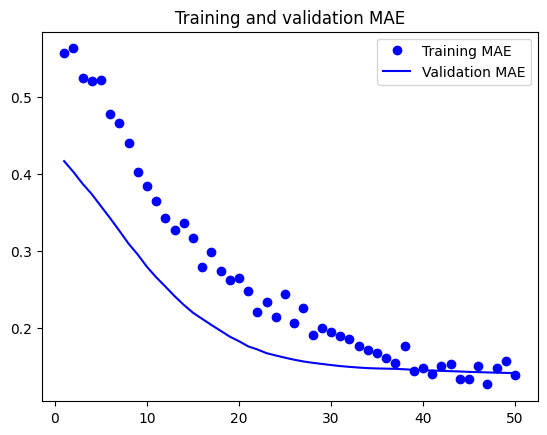

In [5]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Train, Test and Predictions'}, ylabel='y_train'>)

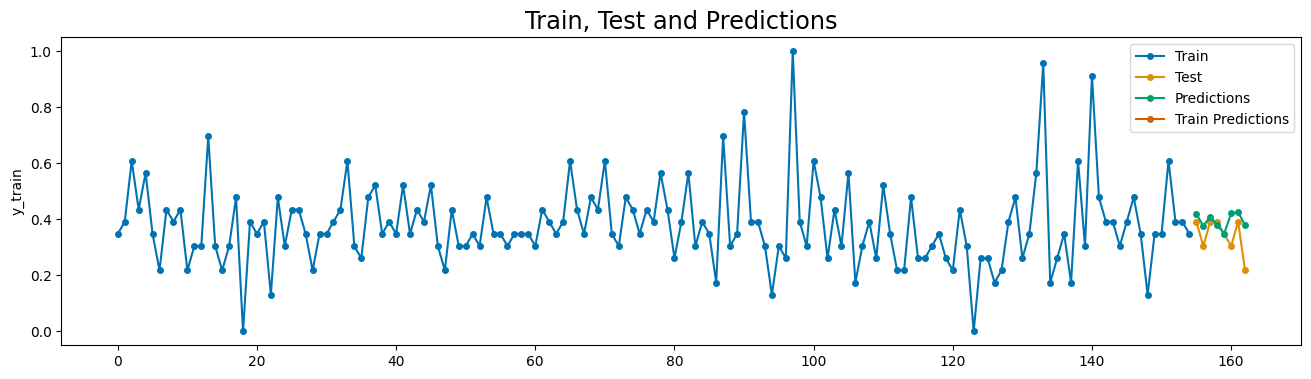

In [6]:
df_plot = pd.DataFrame()
df_plot.index = range(len(y_train) + len(y_test))

y_pred = model.predict(X_test)

df_plot["y_train"] = np.nan
df_plot["y_test"] = np.nan
df_plot["y_pred"] = np.nan
df_plot["y_pred_train"] = np.nan
df_plot.loc[:len(y_train)-1, "y_train"] = y_train
df_plot.loc[len(y_train):, "y_test"] = y_test
df_plot.loc[len(y_train):, "y_pred"] = y_pred


plot_series(
    df_plot["y_train"],
    df_plot["y_test"],
    df_plot["y_pred"],
    df_plot["y_pred_train"],
    labels=["Train", "Test", "Predictions", "Train Predictions"],
    title="Train, Test and Predictions",
)

In [7]:
mae = mean_absolute_error(y_test, df_plot.loc[len(y_train):, "y_pred"])
rmse = np.sqrt(mean_squared_error(y_test, df_plot.loc[len(y_train):, "y_pred"]))

# MASE
naive_forecast = np.roll(y_train, 1)
naive_forecast[0] = y_train[0]
mae_naive = mean_absolute_error(y_train, naive_forecast)
mase = mae / mae_naive

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Scaled Error (MASE): {mase}")

Mean Absolute Error (MAE): 0.055489206119723945
Root Mean Squared Error (RMSE): 0.07691599407453614
Mean Absolute Scaled Error (MASE): 0.3519911384640852
